<img src="images/csdms_logo.jpg">

# Example 3

Use the CSDMS Dakota interface in Python to perform a centered parameter study on [HydroTrend](http://csdms.colorado.edu/wiki/Model_help:HydroTrend) and evaluate the output.

Use `pylab` magic:

In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


And include other necessary imports:

In [51]:
import os

## Set up and run the experiment

Start by importing the `Dakota` class:

In [1]:
from dakota.core import Dakota

Next, create a new `Dakota` instance to perform a centered parameter study:

In [2]:
d = Dakota(method='centered_parameter_study')

Note that `method` string follows the syntax of Dakota keywords; e.g., [centered_parameter_study](https://dakota.sandia.gov/sites/default/files/docs/6.1/html-ref/method-centered_parameter_study.html).

The `Dakota` instance comes with a few predefined attributes, including the `method` attribute, which is used to set up the experiment.

In [7]:
d.__dict__

{'input_file': 'dakota.in',
 'method': <dakota.methods.centered_parameter_study.CenteredParameterStudy at 0x1036aac50>,
 'output_file': 'dakota.out'}

Pull out the `method` attribute to save some time typing in the following steps:

In [14]:
m = d.method
m.__dict__

{'_configuration_file': '/Users/mpiper/projects/mdpiper/dakota-tutorial/notebooks/config.yaml',
 '_initial_point': (0.0, 0.0),
 '_input_files': (),
 '_response_descriptors': ('y1',),
 '_response_files': (),
 '_response_statistics': (),
 '_run_directory': '/Users/mpiper/projects/mdpiper/dakota-tutorial/examples/3-Python',
 '_step_vector': (0.4, 0.5),
 '_steps_per_variable': (5, 4),
 '_template_file': None,
 '_variable_descriptors': ('x1', 'x2'),
 'analysis_driver': 'rosenbrock',
 'component': 'hydrotrend',
 'data_file': 'dakota.dat',
 'id_interface': 'Python',
 'interface': 'fork',
 'is_objective_function': False,
 'method': 'centered_parameter_study',
 'parameters_file': 'params.in',
 'results_file': 'results.out',
 'variable_type': 'continuous_design'}

Configure the `Dakota` instance to run an experiment on HydroTrend
in the **examples/3-Python** directory of this project:

In [15]:
m.component = 'hydrotrend'
m.interface = 'fork'
m.run_directory = '../examples/3-Python/'

The `fork` interface is used when Dakota calls an executable on the file system.

In this experiment, let's explore the effects of mean river velocity $u$ [$m\,s^{-1}$] and the constant annual base flow $q$ [$m^3 s^{-1}$] on the median daily bedload at the river mouth $Q_b$ [$kg\,s^{-1}$] for one year of simulation time. All HydroTrend parameters that are not included in the parameter study are held constant.

First, configure the inputs:

In [52]:
m.variable_descriptors = ['river_mean_velocity', 'base_flow']
m.initial_point = [1.0, 1.0]
m.step_vector = [0.2, 0.25]
m.steps_per_variable = [9, 7]

Note (again) that the attribute names match the Dakota keyword names for a centered parameter study.

From these attributes, calculate the parameter values at which HydroTrend will be evaluated. Use the helper function `calc_vector`.

In [43]:
def calc_vector(start, step_size, n_steps):
    """Calculate a vector from a center, step size and number of steps."""
    v = []
    for i in range(len(start)):
        v_start = start[i] - step_size[i]*(n_steps[i]-1)/2.0
        v_stop = v_start + step_size[i]*n_steps[i]
        v.append(numpy.linspace(v_start, v_stop, n_steps[i], endpoint=False))
    return v

In [59]:
u, q = calc_vector(m.initial_point, m.step_vector, m.steps_per_variable)
print 'u =', u
print 'q =', q

u = [ 0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8]
q = [ 0.25  0.5   0.75  1.    1.25  1.5   1.75]


Make a quick plot to visualize the evaluation nodes in parameter space:

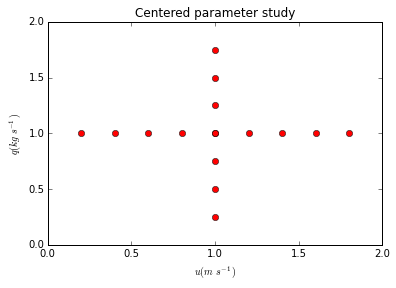

In [60]:
x = [mean(q)]*len(q)
y = [mean(u)]*len(u)
plot(x, q, 'ro')
plot(u, y, 'ro')
xlim((0, 2))
ylim((0, 2))
xlabel('$u (m\,s^{-1})$')
ylabel('$q (kg\,s^{-1})$')
title('Centered parameter study')

Next, set up the responses from HydroTrend used by Dakota. Each of these must be a list or a tuple. (This is a little clumsy.)

In [55]:
m.response_descriptors = 'Qb_median', # must be list or tuple
m.response_statistics = 'median',
m.response_files = 'HYDROASCII.QB',

HydroTrend requires a hypsometry file. The default Waipaoa hypsometry file is included in the run directory. Link it to the `input_files` attribute of the centered parameter study object, which also must be a tuple or a list:

In [54]:
m.input_files = os.path.join(m.run_directory,'HYDRO0.HYPS'),

**Template file.** Use input file with default values from WMT. (My choice.) All parameters that are not included in the parameter study are held constant.

In the final setup step, set the Dakota analysis driver. This is easy, because it's always the same:

In [56]:
m.analysis_driver = 'dakota_run_plugin'

The `dakota_run_plugin` script automates the actions needed for the analysis driver.

(This might be a good time to review the settings for the experiment.)

In [58]:
d.method.__dict__

{'_configuration_file': '/Users/mpiper/projects/mdpiper/dakota-tutorial/notebooks/config.yaml',
 '_initial_point': [1.0, 1.0],
 '_input_files': ('/Users/mpiper/projects/mdpiper/dakota-tutorial/examples/3-Python/HYDRO0.HYPS',),
 '_response_descriptors': ('Qb_median',),
 '_response_files': ('HYDROASCII.QB',),
 '_response_statistics': ('median',),
 '_run_directory': '/Users/mpiper/projects/mdpiper/dakota-tutorial/examples/3-Python',
 '_step_vector': [0.2, 0.25],
 '_steps_per_variable': [9, 7],
 '_template_file': None,
 '_variable_descriptors': ['river_mean_velocity', 'base_flow'],
 'analysis_driver': 'dakota_run_plugin',
 'component': 'hydrotrend',
 'data_file': 'dakota.dat',
 'id_interface': 'Python',
 'interface': 'fork',
 'is_objective_function': False,
 'method': 'centered_parameter_study',
 'parameters_file': 'params.in',
 'results_file': 'results.out',
 'variable_type': 'continuous_design'}

**Write configuration file.** View it.

**Write Dakota input file.** View it.

**Run Dakota.** Look at the results.

## Evaluate the results

Make a plot.

## Modify the experiment

* Use the configuration file created in the initial experiment to create a new `Dakota` instance.
* Modify its settings.
* Save configuration.
* Write new Dakota input file.
* Run modified experiment.